In [1]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from matplotlib import colors

In [24]:
import os

# Define workspace folder
workspace_folder = '/Users/shuyang/Data/DTM/Lake Erie/LIDAR2016to18_DTM-LkErie-R'

# Define specific subfolders based on the workspace
input_folder = os.path.join(workspace_folder, "DTM")  # Input folder for DTM data
adjusted_output_folder = os.path.join(workspace_folder, "DTM_adj")  # Output folder for adjusted rasters
pseudocolor_output_folder = os.path.join(workspace_folder, "pseudocolor")  # Output folder for pseudocolor images


In [25]:
def find_global_min_max(folder):
    global_min, global_max = float('inf'), float('-inf')
    
    for filename in os.listdir(folder):
        if filename.endswith('.img') or filename.endswith('.tif') and not filename.startswith('._'):
            filepath = os.path.join(folder, filename)
            try:
                with rasterio.open(filepath) as dataset:
                    data = dataset.read(1, resampling=Resampling.nearest)  # Read first band
                    no_data_value = dataset.nodata

                    # Mask out NoData values before finding min and max
                    if no_data_value is not None:
                        data = np.ma.masked_equal(data, no_data_value)

                    # Update global min and max
                    min_value = data.min()
                    max_value = data.max()
                    global_min = min(global_min, min_value)
                    global_max = max(global_max, max_value)

            except rasterio.errors.RasterioIOError:
                print(f"Skipping invalid file: {filename}")
    
    return global_min, global_max

In [26]:

# Step 1: Find the minimum and maximum values
min_value, max_value = find_global_min_max(input_folder)
local_min = min_value
local_max  = max_value
print(f"Minimum value of all rasters: {min_value}")
print(f"Maximum value of all rasters: {max_value}")

Minimum value of all rasters: 195.52000427246094
Maximum value of all rasters: 375.239990234375


In [28]:
regional_min = 0
regional_max = 700

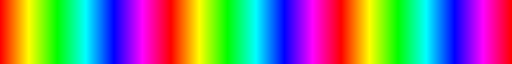

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, hsv_to_rgb

def double_hue_cmap(name='double_hue'):
    # Create an array of values from 0 to 1
    x = np.linspace(0, 1, 2560)

    # Map x to hue values that cycle from 0 to 2 (twice around the hue circle)
    h = np.mod(3 * x, 1)

    # Saturation and Value are fixed at 1
    s = np.ones_like(h) 
    v = np.ones_like(h) 

    # Stack to get HSV values
    hsv = np.stack((h, s, v), axis=1)
    # Convert HSV to RGB
    rgb = hsv_to_rgb(hsv)

    # Create a ListedColormap
    cmap = ListedColormap(rgb, name=name)
    return cmap

# Create the custom colormap
double_cmap = double_hue_cmap()
double_cmap

## Generate Pseudocolor

In [33]:
import os
import numpy as np
import rasterio
from matplotlib import pyplot as plt
from matplotlib import colors

# Function to create a high-resolution colormap by interpolation
def create_high_res_colormap(cmap_name='terrain', num_colors=1024):
    base_cmap = plt.get_cmap(cmap_name)
    color_indices = np.linspace(0, 1, num_colors)
    high_res_cmap = colors.LinearSegmentedColormap.from_list(
        'high_res', base_cmap(color_indices), N=num_colors
    )
    return high_res_cmap

# Main function for creating pseudocolor images using a custom colormap
def create_pseudocolor_images_from_original(folder, min_value, max_value, output_folder, cmap):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    norm = colors.Normalize(vmin=min_value, vmax=max_value)

    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.img') or filename.endswith('.tif') and not filename.startswith('._'):
            filepath = os.path.join(folder, filename)
            try:
                with rasterio.open(filepath) as dataset:
                    # Read the first band and the mask for no-data values
                    data = dataset.read(1)
                    no_data = dataset.nodata

                    # Create a mask for no-data values (True where data is valid)
                    valid_mask = data != no_data

                    # Normalize data and apply high-resolution colormap
                    normalized_data = np.zeros_like(data, dtype=np.float32)
                    normalized_data[valid_mask] = norm(data[valid_mask])

                    # Apply colormap
                    rgba_img = cmap(normalized_data)

                    # Set no-data pixels to transparent
                    rgba_img[~valid_mask, :] = [0, 0, 0, 0]  # RGBA for transparent (alpha = 0)

                    # Convert RGBA to RGB (ignoring the alpha channel)
                    rgb_img = np.uint8(rgba_img[:, :, :3] * 255)

                    # Save as RGB GeoTIFF
                    output_path = os.path.join(output_folder, filename.replace('.img', '_pseudocolor.tif'))
                    with rasterio.open(
                        output_path,
                        'w',
                        driver='GTiff',
                        height=rgb_img.shape[0],
                        width=rgb_img.shape[1],
                        count=3,
                        dtype='uint8',
                        crs=dataset.crs,
                        transform=dataset.transform
                    ) as dst:
                        # Write RGB channels
                        for i in range(3):
                            dst.write(rgb_img[:, :, i], i + 1)

            except rasterio.errors.RasterioIOError:
                print(f"Skipping invalid file: {filename}")



In [35]:
# Step 1: Create the custom colormap
custom_cmap = create_high_res_colormap(cmap_name='terrain', num_colors=5560)

# Step 2: Generate pseudocolor images using the custom colormap
create_pseudocolor_images_from_original(input_folder, regional_min, regional_max, pseudocolor_output_folder, double_cmap)


## DTM_adj

In [36]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling

# Step 2: Rescale raster files based on the global min and max, with no-data handling
def rescale_and_save(folder, output_folder, global_min, global_max, nodata_value=32768):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for filename in os.listdir(folder):
        if filename.endswith('.img') or filename.endswith('tif'):
            filepath = os.path.join(folder, filename)
            with rasterio.open(filepath) as dataset:
                data = dataset.read(1, resampling=Resampling.nearest)  # Read the first band
                
                # Retrieve no-data value from the dataset
                no_data = dataset.nodata

                # Create a mask for valid data
                valid_mask = data != no_data

                # Perform rescaling using global min and max for valid data only
                adjusted_data = np.zeros_like(data, dtype=np.float32)
                adjusted_data[valid_mask] = (data[valid_mask] - global_min) / (global_max - global_min) * 65535
                
                # Set no-data areas to the specified grey value (e.g., 32768 for 16-bit)
                adjusted_data[~valid_mask] = nodata_value

                # Save adjusted raster as GeoTIFF
                output_path = os.path.join(output_folder, filename.replace('.img', '_rescaled.tif'))
                with rasterio.open(
                    output_path,
                    'w',
                    driver='GTiff',
                    height=dataset.height,
                    width=dataset.width,
                    count=1,
                    dtype=rasterio.uint16,  # Save as 16-bit unsigned integer
                    crs=dataset.crs,
                    transform=dataset.transform,
                    nodata=nodata_value  # Set the no-data value for the output file
                ) as dst:
                    dst.write(adjusted_data.astype(rasterio.uint16), 1)

# Rescale and save all files using global min and max
rescale_and_save(input_folder, adjusted_output_folder, local_min, local_max)


In [37]:
def print_lookup_table(global_min, global_max):
    # Generate a sample of original values between the global min and max
    original_values = np.linspace(global_min, global_max, num=10)  # 10 evenly spaced values for the table

    # Calculate corresponding scaled values
    scaled_values = (original_values - global_min) / (global_max - global_min) * 65535

    # Calculate vertical exaggeration
    vertical_exaggeration = 65535 / (global_max - global_min)

    # Print the lookup table
    print("Lookup Table: Original Value -> Scaled Value")
    print("------------------------------------------")
    for original, scaled in zip(original_values, scaled_values):
        print(f"{original:.2f} -> {scaled:.2f}")

    # Print vertical exaggeration
    print("\nVertical Exaggeration:")
    print(f"VE = {vertical_exaggeration:.2f}")
    

print_lookup_table(local_min, local_max)

Lookup Table: Original Value -> Scaled Value
------------------------------------------
195.52 -> 0.00
215.49 -> 7281.67
235.46 -> 14563.33
255.43 -> 21845.00
275.40 -> 29126.67
295.36 -> 36408.33
315.33 -> 43690.00
335.30 -> 50971.67
355.27 -> 58253.33
375.24 -> 65535.00

Vertical Exaggeration:
VE = 364.65


In [38]:
1/364.37 * 500

1.3722315229025441

In [13]:
1/1350 * 500

0.37037037037037035

In [29]:
1/1*500

500.0